In [3]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models


import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
from schemes.avalanche_scheme import avalanche_model, get_slope

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

# Section 5.3

In this section we revisit the simple morphyodynamic model which eliminates the shallow water solved and focuses on just the convection of the the dunes.

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

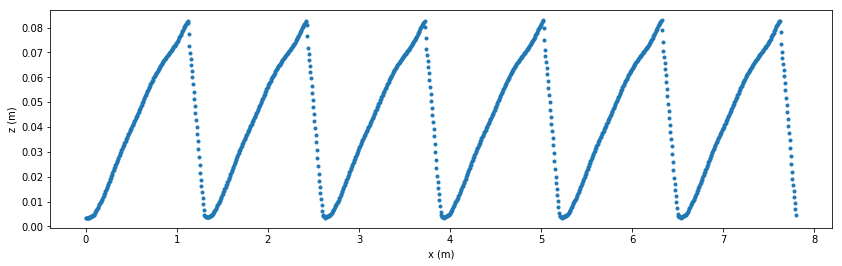

In [4]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [12]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

# Water Surface Elevation
sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------

simTime = 300*60       # Runtime in seconds
dt = 0.25                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 32 cm Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]

$
q_{sb} = \frac{z}{\Delta}q_{sb}^{max}
$

This equation basically says that the bed load is equal to the local local elevation multiplied by the peak bedload. the $q_{sb}^{max}$ is calibrated to match the migration rate of the dune.

 Starting simulation....
Number of time steps: 1200.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483162222
Courant number: max 0.010296508168343828, mean0.010293144653145419
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.042865264831622216
Courant number: max 0.010296508168343828, mean0.010294420592598816
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.04286526483162222
Courant number: max 0.010296508168343873, mean0.01029542036473171
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.042865264831622216
Courant number: max 0.010296508168345805, mean0.01029423444685159
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.042865264831622216
Courant number: max 0.010296508168343857, mean0.01029465340575474
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526483162222
Courant number: max 0.0102

Text(0, 0.5, 'z (m)')

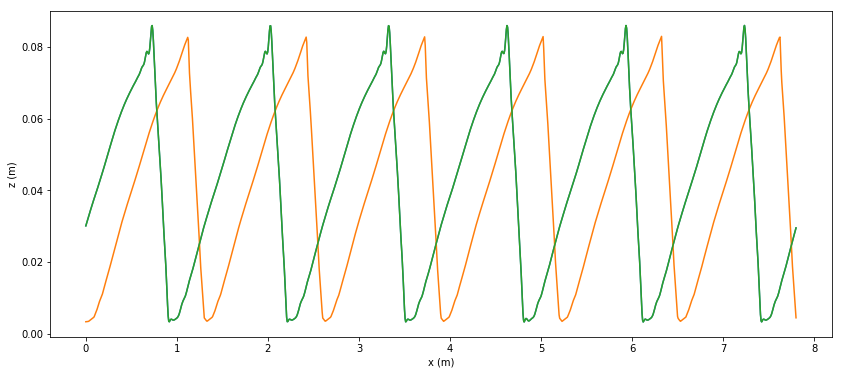

In [13]:
model = parameter_models.ParameterizedMorphologicalModel()

run_name = 'Section_5.3.dune_5_EulerWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy'

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = exner_models.EulerWenoModel()
#morph_model = exner_models.TV
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h


df = model.get_wave_dataframe()
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

Text(0, 0.5, 'z (m)')

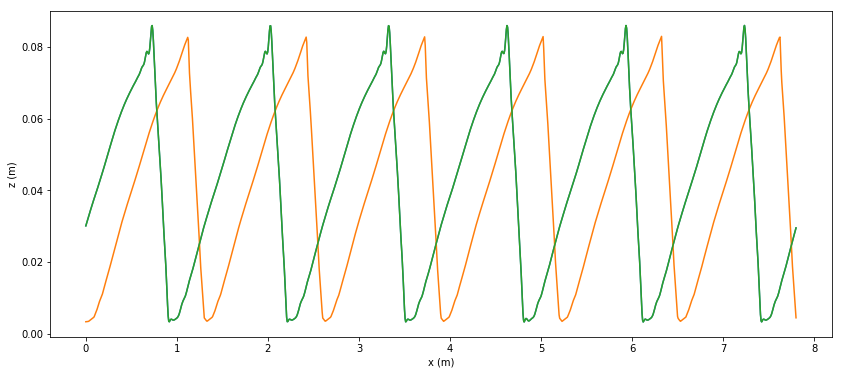

In [14]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [15]:
#--------------------------------
#  Initialize the model
#--------------------------------

model = parameter_models.ParameterizedMorphologicalModel()
model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#-------------------------
# Set the bedload formula
#-------------------------

a = 0.0000127
b = 2
c = 1.
d = -0.02


qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02 #0.2
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

morph_model = exner_models.EulerWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)


xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


Initalized
 Starting simulation....
Number of time steps: 1200.0 mins
Grid dx = 0.0065054211843202665
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.04286526483154591
Courant number: max 0.018898607344946566, mean0.01028136434733988
Time step: 10.0 mins - uavg: 0.0 - Elevation 0.04286526483044148
Courant number: max 0.017423464738761694, mean0.010349850088920757
Time step: 15.0 mins - uavg: 0.0 - Elevation 0.042865264829771065
Courant number: max 0.016372944689897792, mean0.010438194828454471
Time step: 20.0 mins - uavg: 0.0 - Elevation 0.04286526482968624
Courant number: max 0.015579882161123743, mean0.01052386995787561
Time step: 25.0 mins - uavg: 0.0 - Elevation 0.04286526482944444
Courant number: max 0.014947904095109814, mean0.010596063153504552
Time step: 30.0 mins - uavg: 0.0 - Elevation 0.04286526482908718
Courant number: 

Text(0, 0.5, 'z (m)')

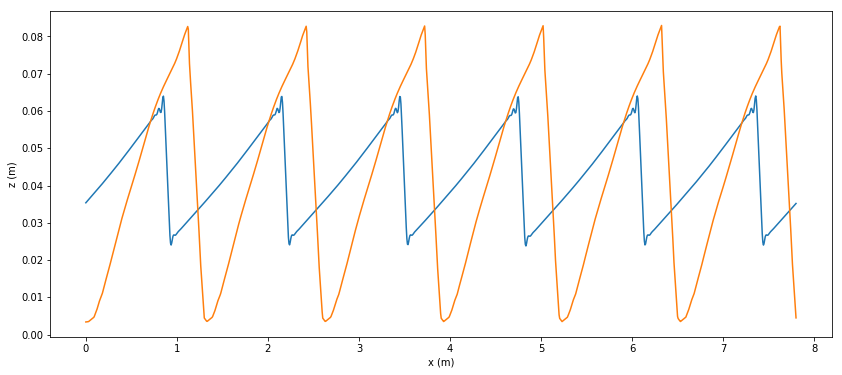

In [16]:
run_name = 'Section_5.3.dune_5_EulerWeno_q_20m_h_237mm_D50_1.0mm_verts.npy'

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
#plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

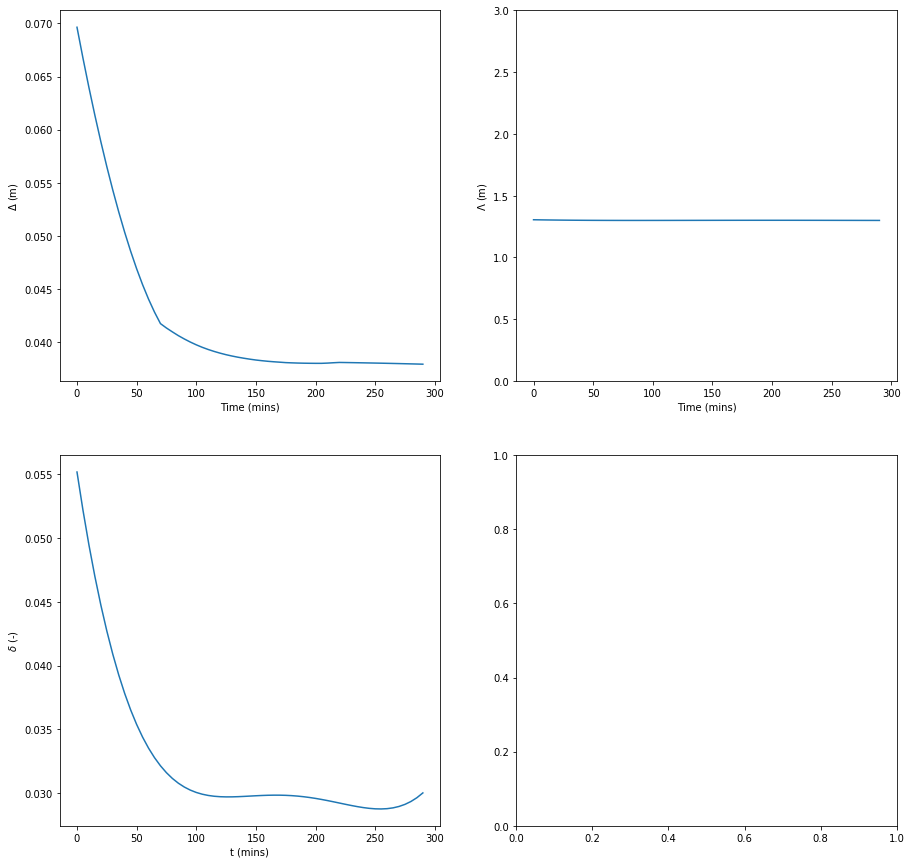

In [17]:
verts = np.load('_output/{0}_verts.npy'.format(run_name))

dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

TypeError: list indices must be integers or slices, not tuple

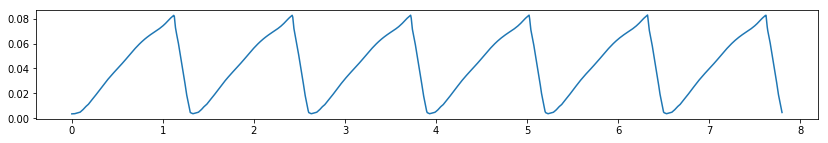

In [14]:
fig = plt.figure(figsize=(14, 2))

plt.plot(x0,z0, label='Inital')

plt.plot(verts[1,:,0], verts[2,:,1], label='t=30 mins')
plt.plot(verts[2,:,0], verts[2,:,1], label='t=30 mins')

plt.plot(verts[3,:,0], verts[3,:,1], label='t=30 mins')

plt.plot(verts[11,:,0], verts[11,:,1], label='t=60 mins')

plt.plot(verts[23,:,0], verts[23,:,1], label='t=120 mins')

plt.plot(verts[35,:,0], verts[35,:,1], label='t=180 mins')

#plt.plot(verts[47,:,0], verts[47,:,1], label='t=240 mins')
plt.legend()

#plt.plot(verts[58,:,0], verts[29,:,1], label='t=300 mins')